# MODEL TRAINING USING PYSPARK

# SUPERVISED LEARNING

In [59]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/bda/prices.csv', header=True, inferSchema=True)
df= df.filter(df['symbol'] == 'AMZN')
df = df.select('volume', 'open', 'close')


In [60]:
assembler = VectorAssembler(inputCols=['volume', 'open'], outputCol="features")
df = assembler.transform(df).select("features", "close")

train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

In [61]:
#Linear Regressor model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="close", predictionCol="prediction")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

#Decision Tree Regressor model
dt = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="close")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

In [62]:
#R2 error mteric
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
lr_r2 = evaluator.evaluate(lr_predictions)
dt_r2 = evaluator.evaluate(dt_predictions)

print("Linear Regression R2:", lr_r2)
print("Decision Tree Regressor R2:", dt_r2)

# Mean Squared Error
evaluator.setMetricName("mse")
lr_mse = evaluator.evaluate(lr_predictions)
dt_mse = evaluator.evaluate(dt_predictions)

print("Linear Regression MSE:", lr_mse)
print("Decision Tree Regressor MSE:", dt_mse)

# Mean Absolute Error
evaluator.setMetricName("mae")
lr_mae = evaluator.evaluate(lr_predictions)
dt_mae = evaluator.evaluate(dt_predictions)

print("Linear Regression MAE:", lr_mae)
print("Decision Tree Regressor MAE:", dt_mae)


Linear Regression R2: 0.9991280518401073
Decision Tree Regressor R2: 0.995417272889222
Linear Regression MSE: 32.373619910410355
Decision Tree Regressor MSE: 170.14711706682277
Linear Regression MAE: 3.8714493361760267
Decision Tree Regressor MAE: 9.083312175293335


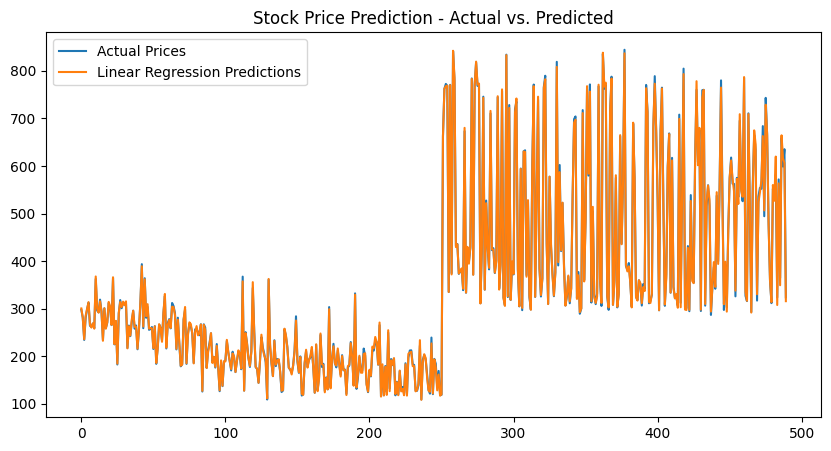

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

lr_pd = lr_predictions.select("prediction", "close").toPandas()

plt.figure(figsize=(10, 5))
plt.plot(lr_pd["close"], label="Actual Prices")
plt.plot(lr_pd["prediction"], label="Linear Regression Predictions")
plt.legend()
plt.title("Stock Price Prediction - Actual vs. Predicted")
plt.show()


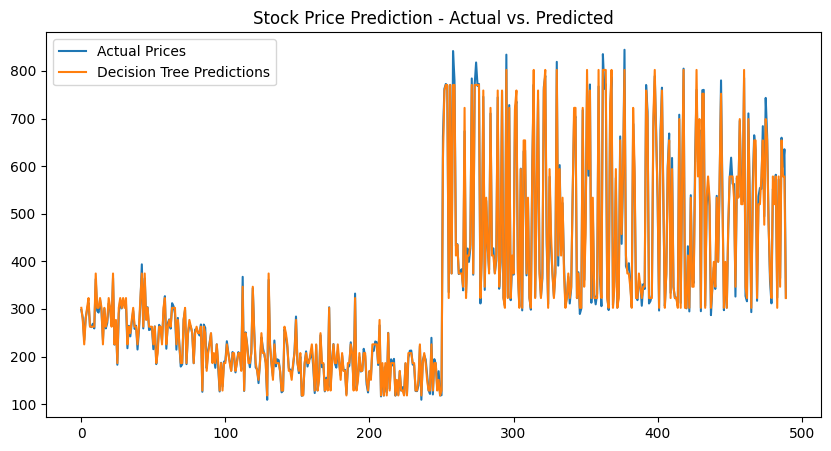

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

dt_pd = dt_predictions.select("prediction", "close").toPandas()

plt.figure(figsize=(10,5))
plt.plot(lr_pd["close"], label="Actual Prices")
plt.plot(dt_pd["prediction"], label="Decision Tree Predictions")
plt.legend()
plt.title("Stock Price Prediction - Actual vs. Predicted")
plt.show()


In [14]:
# Save PySpark model
lr_model.save("/content/drive/MyDrive/Colab Notebooks/bda/linearRegressor.model")
dt_model.save("/content/drive/MyDrive/Colab Notebooks/bda/DecisionTreeRegressor.model")

# UNSUPERVISED LEARNING

In [32]:
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

spark = SparkSession.builder.appName('RainfallClustering').getOrCreate()

df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/bda/Rainfall.csv", header=True, inferSchema=True)
df = df.select([col(c).alias(c.strip()) for c in df.columns])  # Clean column names
df = df.withColumnRenamed("temparature", "temperature")
df = df.dropna(subset=['pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed'])

features = ['pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)


In [33]:
# KMeans Clustering
kmeans = KMeans(k=2, seed=1, featuresCol="features", predictionCol="kmeans_cluster")
kmeans_model = kmeans.fit(df)
kmeans_result = kmeans_model.transform(df)

# Gaussian Mixture Model Clustering
gmm = GaussianMixture(k=2, seed=1, featuresCol="features", predictionCol="gmm_cluster")
gmm_model = gmm.fit(df)
gmm_result = gmm_model.transform(df)


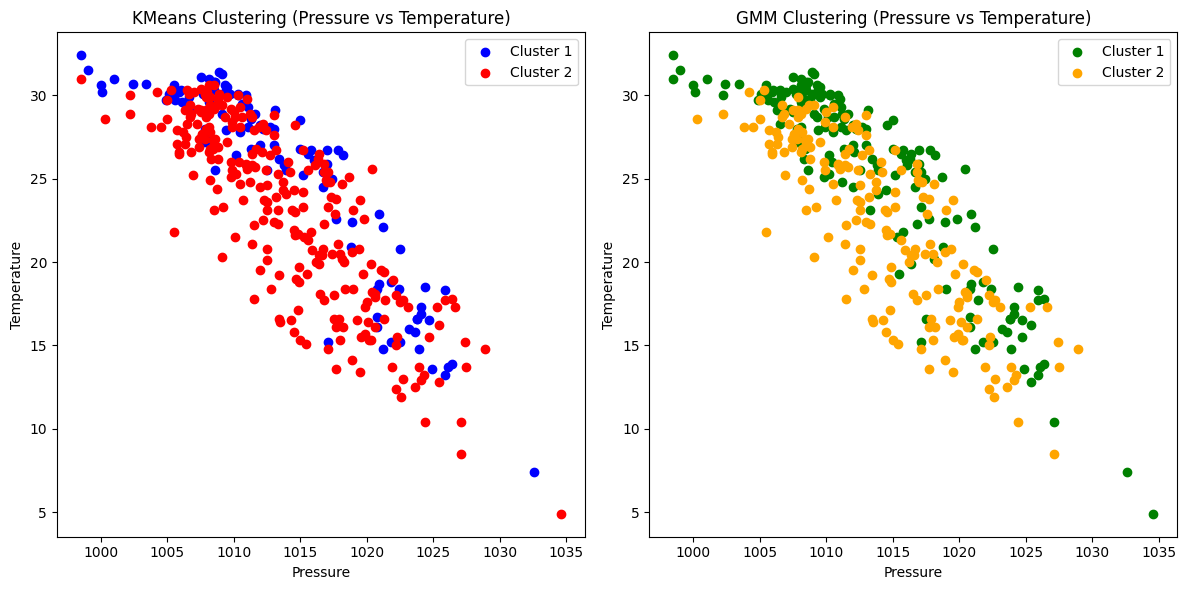

In [34]:
kmeans_data = kmeans_result.select('pressure', 'temperature', 'kmeans_cluster').toPandas()
gmm_data = gmm_result.select('pressure', 'temperature', 'gmm_cluster').toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(kmeans_data[kmeans_data['kmeans_cluster'] == 0]['pressure'],
            kmeans_data[kmeans_data['kmeans_cluster'] == 0]['temperature'],
            color='blue', label='Cluster 1')
plt.scatter(kmeans_data[kmeans_data['kmeans_cluster'] == 1]['pressure'],
            kmeans_data[kmeans_data['kmeans_cluster'] == 1]['temperature'],
            color='red', label='Cluster 2')
plt.title('KMeans Clustering (Pressure vs Temperature)')
plt.xlabel('Pressure')
plt.ylabel('Temperature')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(gmm_data[gmm_data['gmm_cluster'] == 0]['pressure'],
            gmm_data[gmm_data['gmm_cluster'] == 0]['temperature'],
            color='green', label='Cluster 1')
plt.scatter(gmm_data[gmm_data['gmm_cluster'] == 1]['pressure'],
            gmm_data[gmm_data['gmm_cluster'] == 1]['temperature'],
            color='orange', label='Cluster 2')
plt.title('GMM Clustering (Pressure vs Temperature)')
plt.xlabel('Pressure')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
df_features = df.select("features").toPandas()
df_features_scaled = pd.DataFrame(StandardScaler().fit_transform(pd.DataFrame(df_features['features'].tolist())), columns=features)

kmeans_labels = kmeans_result.select("kmeans_cluster").toPandas()['kmeans_cluster'].values
gmm_labels = gmm_result.select("gmm_cluster").toPandas()['gmm_cluster'].values

# Metrics for KMeans
kmeans_silhouette = silhouette_score(df_features_scaled, kmeans_labels)
kmeans_dbi = davies_bouldin_score(df_features_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(df_features_scaled, kmeans_labels)

# Metrics for GMM
gmm_silhouette = silhouette_score(df_features_scaled, gmm_labels)
gmm_dbi = davies_bouldin_score(df_features_scaled, gmm_labels)
gmm_ch = calinski_harabasz_score(df_features_scaled, gmm_labels)

print("Evaluation Metrics:")
print("\nKMeans Clustering:")
print(f"Silhouette Score: {kmeans_silhouette}")
print(f"Davies-Bouldin Index: {kmeans_dbi}")
print(f"Calinski-Harabasz Index: {kmeans_ch}")

print("\nGaussian Mixture Model Clustering:")
print(f"Silhouette Score: {gmm_silhouette}")
print(f"Davies-Bouldin Index: {gmm_dbi}")
print(f"Calinski-Harabasz Index: {gmm_ch}")

Evaluation Metrics:

KMeans Clustering:
Silhouette Score: 0.23979002930646462
Davies-Bouldin Index: 1.7044003017025646
Calinski-Harabasz Index: 91.0662058629003

Gaussian Mixture Model Clustering:
Silhouette Score: 0.22611309175386166
Davies-Bouldin Index: 1.7484526848415494
Calinski-Harabasz Index: 99.00382857798499


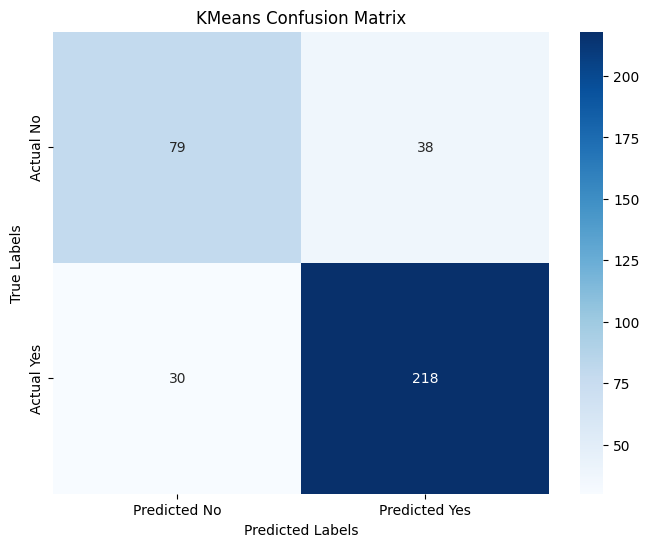

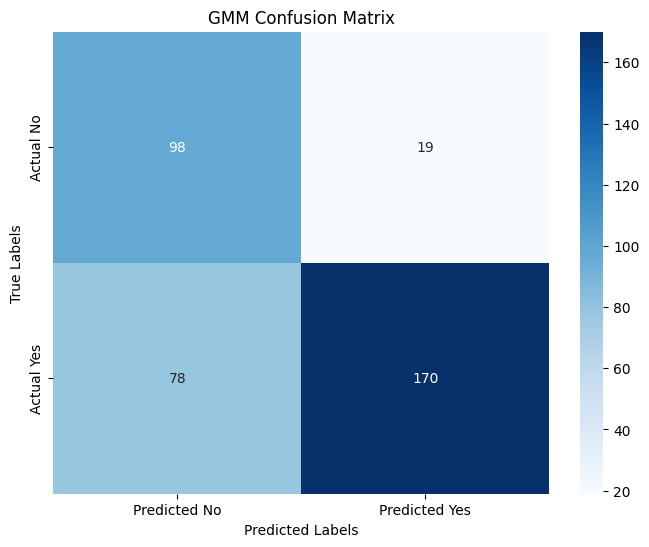

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Label encoding of the true labels (rainfall)
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(df.select('rainfall').toPandas()['rainfall'].values)


# Create confusion matrices
kmeans_cm = confusion_matrix(true_labels, kmeans_labels)
gmm_cm = confusion_matrix(true_labels, gmm_labels)

# Plotting confusion matrix for KMeans
plt.figure(figsize=(8, 6))
sns.heatmap(kmeans_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('KMeans Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Plotting confusion matrix for Gaussian Mixture Model
plt.figure(figsize=(8, 6))
sns.heatmap(gmm_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('GMM Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [41]:
# Save PySpark model
kmeans_model.save("/content/drive/MyDrive/Colab Notebooks/bda/kMeans.model")
gmm_model.save("/content/drive/MyDrive/Colab Notebooks/bda/gaussianMixture.model")

# MODEL TRAINING USING SCIKIT

In [72]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib

In [73]:
rain_path="/content/drive/MyDrive/Colab Notebooks/bda/Rainfall.csv"
stock_path="/content/drive/MyDrive/Colab Notebooks/bda/prices.csv"
path="/content/drive/MyDrive/Colab Notebooks/bda/"

stk_df=pd.read_csv(stock_path)
stk_df = stk_df.loc[(stk_df['symbol'] == 'AMZN')]
rain_df=pd.read_csv(rain_path)

print(stk_df.head(5))
print(rain_df.head(5))

            date symbol        open       close         low        high  \
284   2010-01-04   AMZN  136.250000  133.899994  133.139999  136.610001   
751   2010-01-05   AMZN  133.429993  134.690002  131.809998  135.479996   
1219  2010-01-06   AMZN  134.600006  132.250000  131.649994  134.729996   
1687  2010-01-07   AMZN  132.009995  130.000000  128.800003  132.320007   
2155  2010-01-08   AMZN  130.559998  133.520004  129.029999  133.679993   

          volume  
284    7599900.0  
751    8851900.0  
1219   7178800.0  
1687  11030200.0  
2155   9830500.0  
   day  pressure   maxtemp  temparature  mintemp  dewpoint  humidity   cloud   \
0    1     1025.9     19.9         18.3     16.8      13.1         72      49   
1    2     1022.0     21.7         18.9     17.2      15.6         81      83   
2    3     1019.7     20.3         19.3     18.0      18.4         95      91   
3    4     1018.9     22.3         20.6     19.1      18.8         90      88   
4    5     1015.9     21.3    

In [74]:
print(stk_df.columns)
print(rain_df.columns)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')


In [75]:
X_stk = stk_df.drop(columns=['date','symbol','volume'])
y_stk = stk_df['volume']

X_train, X_test, y_train, y_test = train_test_split(X_stk, y_stk, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)

joblib.dump(lr, path+'linear_regressor_model.pkl')
joblib.dump(dtr, path+'decision_tree_regressor_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/bda/decision_tree_regressor_model.pkl']

In [57]:
rain_df['rainfall'] = rain_df['rainfall'].map({'yes': 1, 'no': 0})

rain_features = rain_df.drop(columns=['day', 'rainfall', 'sunshine', '         winddirection'])

rain_features = rain_features.fillna(rain_features.mean())

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_model = kmeans.fit(rain_features)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_model = gmm.fit(rain_features)

joblib.dump(kmeans_model, path+'kmeans_model.pkl')
joblib.dump(gmm_model, path+'gaussian_mixture_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/bda/gaussian_mixture_model.pkl']